# Advanced Features

When analyzing the real world datasets, we may have the following targets:

1. certain variables must be selected when some prior information is given;
2. selecting the weak signal variables when the prediction performance is mainly interested;
3. identifying predictors when group structure are provided;
4. pre-excluding a part of predictors when datasets have ultra high-dimensional predictors;
5. specify the division of sample in cross validation;
6. specify the initial active set before splicing.

In the following content, we will illustrate the statistic methods to reach these targets in a one-by-one manner, and give quick examples to show how to perform the statistic methods in `abessLm` and the same steps can be implemented in all methods. Actually, in our methods, the targets can be properly handled by simply change some default arguments in the functions. 

## Nuisance Regression

Nuisance regression refers to best subset selection with some prior information that some variables are required to stay in the active set. For example, if we are interested in a certain gene and want to find out what other genes are associated with the response when this particular gene shows effect.

In the `abessLm()` (or other methods), the argument `always_select` is designed to realize this goal. User can pass a vector containing the indexes of the target variables to `always_select`. Here is an example.

In [2]:
import numpy as np
from abess.datasets import make_glm_data
from abess.linear import abessLm

np.random.seed(0)

# gene data
n = 100
p = 20
k = 5
dt = make_glm_data(n = n, p = p, k = k, family = 'gaussian')
print('real coefficients:\n', dt.coef_, '\n')
print('real coefficients\' indexes:\n', np.nonzero(dt.coef_)[0])

real coefficients:
 [  0.           0.         115.01218243   0.           0.
  81.84924757   0.           0.           0.           0.
 104.77568224  64.30426355   0.           0.           0.
   0.           0.           0.         108.5408557    0.        ] 

real coefficients' indexes:
 [ 2  5 10 11 18]


In [2]:
model = abessLm(support_size = range(0, 6))
model.fit(dt.x, dt.y)
print('fitted coefficients:\n', model.coef_, '\n')
print('fitted coefficients\' indexes:\n', np.nonzero(model.coef_)[0])

fitted coefficients:
 [  0.           0.         114.93792167   0.           0.
  81.8124385    0.           0.           0.           0.
 104.67076232  64.40856101   0.           0.           0.
   0.           0.           0.         108.73726174   0.        ] 

fitted coefficients' indexes:
 [ 2  5 10 11 18]


The coefficients are located in \[2, 5, 10, 11, 18\]. 
But if we suppose that the 7th and 8th variables are worthy to be included in the model, we can call:

In [3]:
model = abessLm(support_size = range(0, 6), always_select = [7, 8])
model.fit(dt.x, dt.y)
print('fitted coefficients:\n', model.coef_, '\n')
print('fitted coefficients\' indexes:\n', np.nonzero(model.coef_)[0])

fitted coefficients:
 [  0.           0.         117.18370615   0.           0.
   0.           0.           5.09643891  -1.00521149   0.
  91.65760504   0.           0.           0.           0.
   0.           0.           0.         121.21120638   0.        ] 

fitted coefficients' indexes:
 [ 2  7  8 10 18]


Now the variables we chosen are always in the model.

## Regularized Adaptive Best Subset Selection

In some cases, especially under low signal-to-noise ratio (SNR) setting or predictors are highly correlated, the vallina type of $L_0$ constrained model may not be satisfying and a more sophisticated trade-off between bias and variance is needed. Under this concern, the `abess` pakcage provides option of best subset selection with $L_2$ norm regularization called the regularized bess. The model has this following form:

$$
\begin{align}
    \arg\min_\beta L(\beta) + \alpha \|\beta\|_2^2.
\end{align}
$$

To implement the regularized bess, user need to specify a value to an additive argument `alpha` in the `abessLm()` function (or other methods). This value corresponds to the penalization parameter in the model above. 

Let’s test the regularized best subset selection against the no-regularized one over 100 replicas in terms of prediction performance. With argument `snr` in `make_glm_data()`, we can add white noise into generated data.

In [3]:
loss = np.zeros((2, 100))
coef = np.repeat([1, 0], [5, 25])
for i in range(100):
    np.random.seed(i)
    train = make_glm_data(n = 100, p = 30, k = 5, family = 'gaussian', coef_ = coef, snr = 0.05)
    np.random.seed(i + 100)
    test = make_glm_data(n = 100, p = 30, k = 5, family = 'gaussian', coef_ = coef, snr = 0.05)
    
    # normal
    model = abessLm()
    model.fit(train.x, train.y)
    loss[0, i] = np.linalg.norm(model.predict(test.x) - test.y)
    # regularized
    model = abessLm(alpha = 0.7)
    model.fit(train.x, train.y)
    loss[1, i] = np.linalg.norm(model.predict(test.x) - test.y)

print("normal model's loss:", np.mean(loss[0,:]))
print("regularized model's loss:", np.mean(loss[1,:]))

normal model's loss: 24.709066304317844
regularized model's loss: 23.416157533057604


The regularized model has a lower test loss. And we can also make a boxplot:

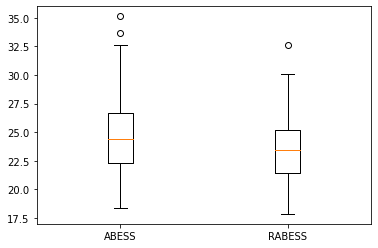

In [4]:
import matplotlib.pyplot as plt
plt.boxplot([loss[0,:], loss[1,:]], labels = ['ABESS', 'RABESS'])
plt.show()

We see that the regularized best subset select ("RABESS" in figure)  indeed reduces the prediction error.

## Best group subset selection

Best group subset selection (BGSS) aims to choose a small part of non-overlapping groups to achieve the best interpretability on the response variable. BGSS is practically useful for the analysis of ubiquitously existing variables with certain group structures. For instance, a categorical variable with several levels is often represented by a group of dummy variables. Besides, in a nonparametric additive model, a continuous component can be represented by a set of basis functions (e.g., a linear combination of spline basis functions). Finally, specific prior knowledge can impose group structures on variables. A typical example is that the genes belonging to the same biological pathway can be considered as a group in the genomic data analysis.

The BGSS can be achieved by solving:

$$
    \min_{\beta\in \mathbb{R}^p} \frac{1}{2n} ||y-X\beta||_2^2,\quad s.t.\ ||\beta||_{0,2}\leq s .
$$

where $||\beta||_{0,2} = \sum_{j=1}^J I(||\beta_{G_j}||_2\neq 0)$ in which $||\cdot||_2$ is the $L_2$ norm and model size $s$ is a positive integer to be determined from data. Regardless of the NP-hard of this problem, Zhang et al develop a certifiably polynomial algorithm to solve it. This algorithm is integrated in the `abess` package, and user can handily select best group subset by assigning a proper value to the `group` arguments:

We still use the dataset `dt` generated before, which has 100 samples, 5 useful variables and 15 irrelevant varibales.

In [178]:
print('real coefficients:\n', dt.coef_, '\n')

real coefficients:
 [  0.           0.         115.01218243   0.           0.
  81.84924757   0.           0.           0.           0.
 104.77568224  64.30426355   0.           0.           0.
   0.           0.           0.         108.5408557    0.        ] 



Support we have some prior information that every 5 variables as a group:

In [179]:
group = np.linspace(0, 3, 4).repeat(5)
print('group index:\n', group)

group index:
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3.]


Then we can set the `group` argument in function. Besides, the `support_size` here indicates the number of groups, instead of the number of variables.

In [180]:
model = abessLm(support_size = range(0, 3))
model.fit(dt.x, dt.y, group = group)
print('coefficients:\n', model.coef_)

coefficients:
 [  4.07330876  14.02654966 133.63659942  -3.25926433  -8.02172721
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  -4.14697258   1.53447211  16.29386214 112.43896075   8.85388996]


The fitted result suggest that only two groups are selected (since `support_size` is from 0 to 2) and the selected variables are shown before.

## Integrate SIS

Ultra-high dimensional predictors increase computational cost but reduce estimation accuracy for any statistical procedure. To reduce dimensionality from high to a relatively acceptable level, a fairly general asymptotic framework, named feature screening (sure independence screening) is proposed to tackle even exponentially growing dimension. The feature screening can theoretically maintain all effective predictors with a high probability, which is called "the sure screening property".

In our program, to carrying out the Integrate SIS, user need to pass an integer smaller than the number of the predictors to the `screening_size`. Then the program will first calculate the marginal likelihood of each predictor and reserve those predictors with the `screening_size` largest marginal likelihood. Then, the ABESS algorithm is conducted only on this screened subset. 

Here is an example.

In [181]:
n = 100
p = 1000
k = 3
np.random.seed(2)

# gene data
dt = make_glm_data(n = n, p = p, k = k, family = 'gaussian')
print('real coefficients\' indexes:', np.nonzero(dt.coef_)[0])

# fit
model = abessLm(support_size = range(0, 5), screening_size = 100)
model.fit(dt.x, dt.y)
print('fitted coefficients\' indexes:', np.nonzero(model.coef_)[0])

real coefficients' indexes: [243 295 659]
fitted coefficients' indexes: [243 295 659]


## User-specified cross validation division

Sometimes, especially when running a test, we would like to fix the train and valid data used in cross validation, instead of choosing them randomly.
One simple method is to fix a random seed, such as `numpy.random.seed()`. But in some cases, we would also like to specify which samples would be in the same "fold", which has great flexibility.

In our program, an additional argument `cv_fold_id` is for this user-specified cross validation division. An integer array with the same size of input samples can be given, and those with same integer would be assigned to the same "fold" in K-fold CV.

In [3]:
n = 100
p = 1000
k = 3
np.random.seed(2)

dt = make_glm_data(n = n, p = p, k = k, family = 'gaussian')

# cv_fold_id has a size of `n`
# cv_fold_id has `cv` different integers
cv_fold_id = [1 for i in range(30)] + [2 for i in range(30)] + [3 for i in range(40)] 

model = abessLm(support_size = range(0, 5), cv = 3)
model.fit(dt.x, dt.y, cv_fold_id = cv_fold_id)
print('fitted coefficients\' indexes:', np.nonzero(model.coef_)[0])

fitted coefficients' indexes: [243 295 659]


## User-specified initial active set

We believe that it worth allowing given an initial active set so that the splicing process starts from this set for each sparsity. 
It might come from prior analysis, whose result is not quite precise but better than random selection, so the algorithm can run more efficiently. Or you just want to give different initial sets to test the stability of the algorithm.

*Note that this is NOT equal to `always_select`, since they can be exchanged to inactive set when splicing.*

To specify initial active set, an additive argument `A_init` should be given in `fit()`.

In [3]:
n = 100
p = 10
k = 3
np.random.seed(2)

dt = make_glm_data(n = n, p = p, k = k, family = 'gaussian')

model = abessLm(support_size = range(0, 5))
model.fit(dt.x, dt.y, A_init = [0, 1, 2])

abessLm(always_select=[], support_size=range(0, 5))

Some strategies for initial active set are:

- If $sparsity = len(A\_init)$, the splicing process would start from $A\_init$.
- If $sparsity > len(A\_init)$, the initial set includes $A\_init$ and other variables `inital screening` chooses.
- If $sparsity < len(A\_init)$, the initial set includes part of $A\_init$.
- If both `A_init` and `always_select` are given, `always_select` first.
- For warm-start, `A_init` will only affect splicing under the first sparsity in `support_size`.
- For CV, `A_init` will affect each fold but not the re-fitting on full data.

## R tutorial

For R tutorial, please view [https://abess-team.github.io/abess/articles/v07-advancedFeatures.html](https://abess-team.github.io/abess/articles/v07-advancedFeatures.html).